In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
import cmath

In [11]:
import copy

#### Cameraman image

In [2]:
img = Image.open("./cameraman.png")

In [3]:
img_array = np.asarray(img)

In [4]:
def noise_iid(img, mean=0.0, sigma=1.00):
    nx,ny,nz = img.shape[:3]
    gnoise = np.random.normal(mean, sigma, (nx,ny,nz))
    gnoise = gnoise.reshape(nx,ny,nz)
    return img + gnoise

In [431]:
nimg = noise_iid(img_array[:512,:512,:], sigma=0.1)

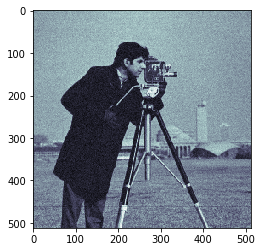

In [8]:
plt.imshow(nimg[:,:,0], cmap='bone')

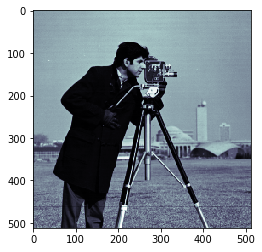

In [432]:
plt.imshow(nimg[:,:,0], cmap='bone')

In [9]:
nimg.shape

(512, 512, 3)

#### Haar wavelet

In [10]:
nx, ny = nimg.shape[:2]

##### 1D Haar

In [12]:
tmp = [ 1.000  , 2.000  , 3.000,   1.000  , 2.000  , 3.000  , 4.000 ,  0.000 ]

In [13]:
tmp

[1.0, 2.0, 3.0, 1.0, 2.0, 3.0, 4.0, 0.0]

In [116]:
c = [] # sum
d = [] #diff
for i in range(int(len(tmp)/2)):
    c += [(tmp[2*i]+tmp[2*i+1])/math.sqrt(2)]
    d += [(tmp[2*i]-tmp[2*i+1])/math.sqrt(2)]
theta = c+d

In [117]:
c

[2.1213203435596424, 2.82842712474619, 3.5355339059327373, 2.82842712474619]

In [118]:
d

[-0.7071067811865475, 1.414213562373095, -0.7071067811865475, 2.82842712474619]

In [119]:
theta

[2.1213203435596424,
 2.82842712474619,
 3.5355339059327373,
 2.82842712474619,
 -0.7071067811865475,
 1.414213562373095,
 -0.7071067811865475,
 2.82842712474619]

#### functionize

In [177]:
def haar_1d(img, plevel=1):
    theta = copy.deepcopy(img)
    for ip in range(1,plevel+1,1):
        c = [] # sum
        d = [] #diff
        for i in range(int(len(img)/2/ip)):
            c += [(theta[2*i]+theta[2*i+1])/math.sqrt(2)]
            d += [(theta[2*i]-theta[2*i+1])/math.sqrt(2)]
        theta[0:int(len(img)/2/ip)] = c
        theta[int(len(img)/2/ip):int(len(img)/2/ip)+len(d)] = d
    return theta

### bug fix version below

In [357]:
def haar_1d(img, plevel=1):
    theta = copy.deepcopy(img)
    for ip in range(1,plevel+1,1):
        c = [] # sum
        d = [] #diff
        for i in range(int(len(img)/(2**ip))):
            c += [(theta[2*i]+theta[2*i+1])/math.sqrt(2)]
            d += [(theta[2*i]-theta[2*i+1])/math.sqrt(2)]
        theta[0:int(len(img)/(2**ip))] = c
        theta[int(len(img)/(2**ip)):int(len(img)/(2**ip))+len(d)] = d
    return theta

In [358]:
haar = haar_1d(tmp, plevel=1)

In [359]:
haar

[2.1213203435596424,
 2.82842712474619,
 3.5355339059327373,
 2.82842712474619,
 -0.7071067811865475,
 1.414213562373095,
 -0.7071067811865475,
 2.82842712474619]

In [360]:
haar = haar_1d(tmp, plevel=2)

In [361]:
haar

[3.499999999999999,
 4.5,
 -0.49999999999999994,
 0.49999999999999994,
 -0.7071067811865475,
 1.414213562373095,
 -0.7071067811865475,
 2.82842712474619]

In [72]:
haar = haar_1d(tmp, plevel=3)

0
1
2
3
0
1
0


In [73]:
haar

[5.656854249492379,
 -0.7071067811865481,
 -0.49999999999999994,
 0.49999999999999994,
 -0.7071067811865475,
 1.414213562373095,
 -0.7071067811865475,
 2.82842712474619]

#### 2D Haar Wavelet Transform

(512, 512, 3)


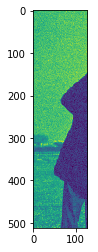

In [82]:
tmp = np.zeros((512,512,3))
print(tmp.shape)
tmp = nimg[:,:128]
plt.imshow(tmp[:,:,0])

In [101]:
def haar_2d(img, plevel=1):
    nx, ny, nz = img.shape[:3]
    rgb_list = []
    for iz in range(nz): #rgb band
        col_haar = []
        for iy in range(ny):
            col_haar += [haar_1d(img[:,iy,iz], plevel=plevel)]
        col_array = np.asarray(col_haar) #  array[ix,iy] ==> col_array[iy,ix]
        row_haar = []
        for ix in range(nx):
            row_haar += [haar_1d(col_array[:,ix], plevel=plevel)]
        rgb_list += [np.asarray(row_haar)]
    return rgb_list

In [144]:
rgbs = haar_2d(nimg, plevel=1)

In [103]:
rgbs[0].shape

(512, 512)

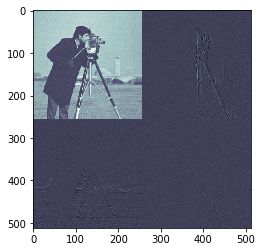

In [104]:
plt.imshow(rgbs[0], cmap='bone')

#### inverse 1d

In [105]:
tmp = [ 1.000  , 2.000  , 3.000,   1.000  , 2.000  , 3.000  , 4.000 ,  0.000 ]
n = len(tmp)

In [113]:
w = np.zeros((n,n))
coef = 1/math.sqrt(2)
for j in range(int(n/2)):
    #for i in range(int(n/2)):
        w[2*j,j] = 1
        w[2*j+1,j] = 1
        w[2*j, int(n/2)+j] = 1
        w[2*j+1, int(n/2)+j] = -1
w = coef*w.T # transpose

In [112]:
w # no coef version

array([[ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]])

In [114]:
w

array([[ 0.70710678,  0.70710678,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.70710678,
         0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.70710678, -0.70710678,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.70710678,
        -0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.70710678, -0.70710678]])

In [126]:
inv_w =  np.linalg.inv(w)

In [127]:
inv_w

array([[ 0.70710678,  0.        ,  0.        ,  0.        ,  0.70710678,
         0.        ,  0.        ,  0.        ],
       [ 0.70710678, -0.        , -0.        , -0.        , -0.70710678,
        -0.        , -0.        , -0.        ],
       [ 0.        ,  0.70710678,  0.        ,  0.        ,  0.        ,
         0.70710678,  0.        ,  0.        ],
       [-0.        ,  0.70710678, -0.        , -0.        , -0.        ,
        -0.70710678, -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.70710678,  0.        ,  0.        ,
         0.        ,  0.70710678,  0.        ],
       [-0.        , -0.        ,  0.70710678, -0.        , -0.        ,
        -0.        , -0.70710678, -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.70710678,  0.        ,
         0.        ,  0.        ,  0.70710678],
       [-0.        , -0.        , -0.        ,  0.70710678, -0.        ,
        -0.        , -0.        , -0.70710678]])

In [130]:
inv_f = inv_w.dot(np.asarray(theta))

In [131]:
inv_f

array([1., 2., 3., 1., 2., 3., 4., 0.])

In [137]:
def inv_haar_1d(array):
    """ plevel == 1
        array: wavelet 1d vector
    """
    n = len(array)
    def gen_w(n=2):
        w = np.zeros((n,n))
        coef = 1/math.sqrt(2)
        for j in range(int(n/2)):
            w[2*j,j] = 1
            w[2*j+1,j] = 1
            w[2*j, int(n/2)+j] = 1
            w[2*j+1, int(n/2)+j] = -1
        return coef*w.T # transpose
    inv_w = np.linalg.inv(gen_w(n=n))
    inv_f = inv_w.dot(np.asarray(array))
    return inv_f

In [138]:
_inv_f = inv_haar_1d(theta)

In [139]:
_inv_f

array([1., 2., 3., 1., 2., 3., 4., 0.])

#### inverse 2d

In [149]:
def inv_haar_2d(wave_img, plevel=1):
    nx, ny = wave_img.shape[:2]
    inv_haar = []
    for iy in range(ny):
        inv_haar += [inv_haar_1d(wave_img[:,iy])]
    col_array = np.asarray(inv_haar) #  array[ix,iy] ==> col_array[iy,ix]
    row_haar = []
    for ix in range(nx):
        row_haar += [inv_haar_1d(col_array[:,ix])]
    return np.asarray(row_haar)

In [150]:
inv_array = inv_haar_2d(rgbs[0])

In [151]:
inv_array.shape

(512, 512)

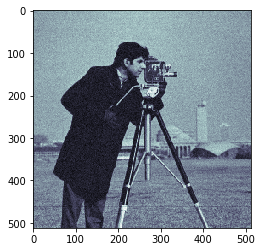

In [152]:
plt.imshow(inv_array, cmap='bone')

In [153]:
res = nimg[:,:,0] - inv_array

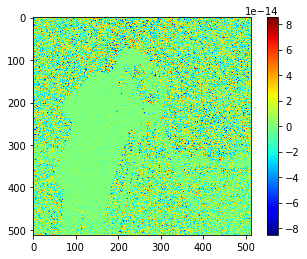

In [154]:
plt.imshow(res, cmap='jet')
plt.colorbar()

In [155]:
MSE = 1/(nx*ny)*sum([ res.flatten()[i] for i in range(nx*ny)])

In [156]:
MSE

2.6967742330453808e-17

In [398]:
res1 = nimg[:,:,0] - img_array[:512,:512,0]
#res2 = inv_array - img_array[:512,:512,0]

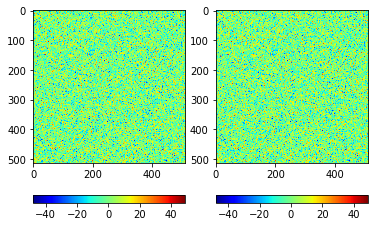

In [169]:
plt.figure()
ax = plt.subplot(121)
plt.imshow(res1, cmap='jet')
plt.colorbar(orientation='horizontal')
ax = plt.subplot(122)
plt.imshow(res2, cmap='jet')
plt.colorbar(orientation='horizontal')

In [399]:
MSE1 = 1/(nx*ny)*sum([ (res1.flatten()[i])**2 for i in range(nx*ny)])

In [161]:
MSE2 = 1/(nx*ny)*sum([ res2.flatten()[i] for i in range(nx*ny)])

In [400]:
MSE1

99.77202768449973

In [162]:
MSE1, MSE2

(-0.017869505371065773, -0.017869505371065856)

### multiple p levels

In [366]:
def inv_haar_1d(array,plevel=1):
    """ plevel == 1
        array: wavelet 1d vector
    """
    n = len(array)
    coef = 1/math.sqrt(2)
    for _ip in range(plevel+1,1,-1):
        ip=_ip-1
        tmp = np.zeros((n))
        for i in range(int(n/(2**ip))):
            tmp[2*i] =coef*(array[i]+array[int(n/(2**ip))+i])
            tmp[2*i+1] = coef*(array[i]-array[int(n/(2**ip))+i])
        #print(tmp)
        array[0:2*int(n/(2**ip))] = tmp[0:2*int(n/(2**ip))]
    return array

In [352]:
haar = haar_1d(tmp, plevel=3)

In [354]:
ihaar = inv_haar_1d(haar, plevel=3)

[3.5 4.5 0.  0.  0.  0.  0.  0. ]
[2.12132034 2.82842712 3.53553391 2.82842712 0.         0.
 0.         0.        ]
[ 1.00000000e+00  2.00000000e+00  3.00000000e+00  1.00000000e+00
  2.00000000e+00  3.00000000e+00  4.00000000e+00 -3.14018492e-16]


In [353]:
haar

[5.656854249492379,
 -0.7071067811865481,
 -0.49999999999999994,
 0.49999999999999994,
 -0.7071067811865475,
 1.414213562373095,
 -0.7071067811865475,
 2.82842712474619]

In [355]:
ihaar

[0.9999999999999989,
 1.9999999999999987,
 2.9999999999999987,
 0.9999999999999989,
 1.9999999999999993,
 2.9999999999999987,
 3.999999999999999,
 -3.14018491736755e-16]

In [362]:
def inv_haar_2d(wave_img, plevel=1):
    nx, ny = wave_img.shape[:2]
    inv_haar = []
    for iy in range(ny):
        inv_haar += [inv_haar_1d(wave_img[:,iy], plevel=plevel)]
    col_array = np.asarray(inv_haar) #  array[ix,iy] ==> col_array[iy,ix]
    row_haar = []
    for ix in range(nx):
        row_haar += [inv_haar_1d(col_array[:,ix], plevel=plevel)]
    return np.asarray(row_haar)

In [433]:
rgbs = haar_2d(nimg, plevel=5)

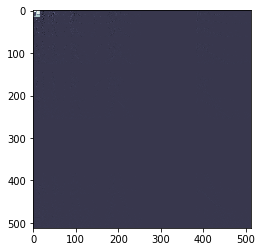

In [434]:
plt.imshow(rgbs[0], cmap='bone')

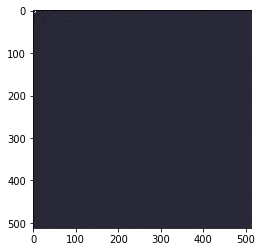

In [420]:
plt.imshow(rgbs[0], cmap='bone')

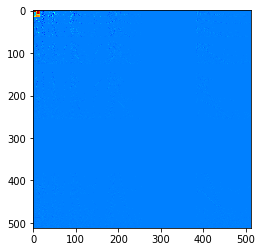

In [435]:
plt.imshow(rgbs[0], cmap='jet')

In [436]:
_r =  copy.deepcopy(rgbs[0])

In [437]:
inv_array = inv_haar_2d(_r, plevel=5)

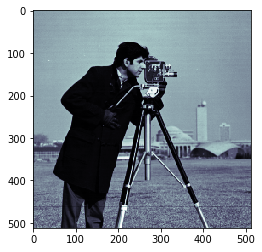

In [438]:
plt.imshow(inv_array, cmap='bone')

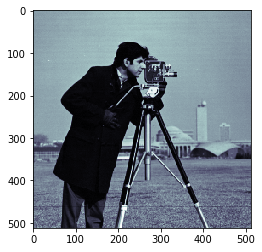

In [407]:
plt.imshow(inv_array, cmap='bone')

In [439]:
err = inv_array - img_array[:512,:512,0]

In [408]:
_err = inv_array - img_array[:512,:512,0]

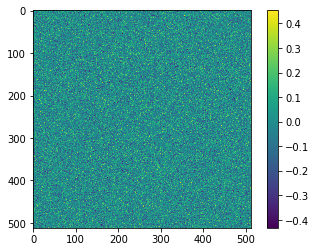

In [440]:
plt.imshow(err)
plt.colorbar()

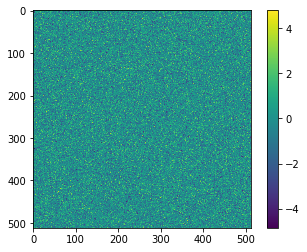

In [409]:
plt.imshow(_err)
plt.colorbar()

In [396]:
mserr = 1/(nx*ny)*sum([ abs(err.flatten()[i])**2 for i in range(nx*ny)])

In [410]:
1/(nx*ny)*sum([ (_err.flatten()[i])**2 for i in range(nx*ny)])

1.000499854182022

In [397]:
mserr

99.77202768449963

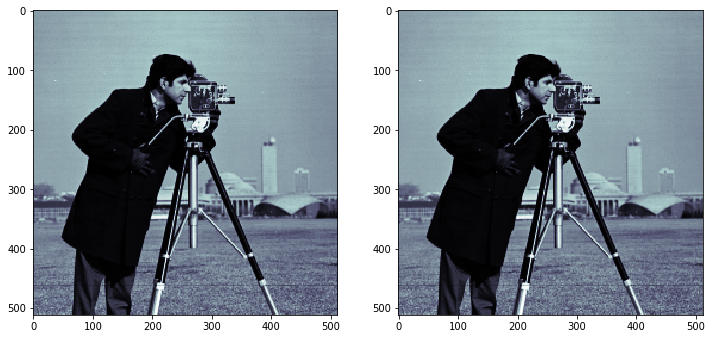

In [441]:
plt.figure(figsize=(12,12))
ax = plt.subplot(121)
plt.imshow(inv_array, cmap='bone')
ax = plt.subplot(122)
plt.imshow(nimg[:,:,0], cmap='bone')

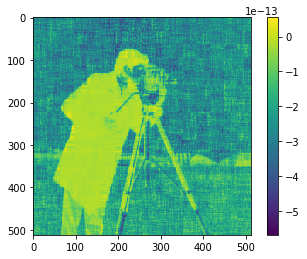

In [443]:
a = inv_array - nimg[:,:,0]
plt.imshow(a)
plt.colorbar()